In [1]:
WIDTH, HEIGHT, CHANNELS = 160, 100, 3
MODEL_NUMBER = 2
MODEL_NAME = 'autoencoder-'+str(MODEL_NUMBER)

In [2]:
import tflearn
import numpy as np
from tflearn.layers.conv import conv_2d, max_pool_2d, upsample_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.recurrent import gru

def build_model():
    input_img = input_data(shape=(HEIGHT, WIDTH, CHANNELS), name='input')                 ; print(input_img.shape)
    INPUT = input_img
    x = conv_2d(input_img, 16, (3, 3), activation='relu', padding='same')   ; print(x.shape)
    x = max_pool_2d(x, (2, 2), padding='same')                              ; print(x.shape)
    x = conv_2d(x, 8, (3, 3), activation='relu', padding='same')            ; print(x.shape)
    x = max_pool_2d(x, (2, 2), padding='same')                              ; print(x.shape)
    x = conv_2d(x, 8, (3, 3), activation='relu', padding='same')            ; print(x.shape)
    encoded = max_pool_2d(x, (2, 2), padding='same')                        ; print(encoded.shape)# at this point the representation is (4, 4, 8) i.e. 128-dimensional

    HIDDEN_STATE = encoded
    print("middle")

    x = conv_2d(encoded, 8, (3, 3), activation='relu', padding='same', name='input2')      ; print(x.shape)
    x = upsample_2d (x, (2, 2))                                             ; print(x.shape)
    x = conv_2d(x, 8, (3, 3), activation='relu', padding='same')            ; print(x.shape)
    x = upsample_2d (x, (2, 2))                                             ; print(x.shape)
    x = conv_2d(x, 16, (3, 3), activation='relu', padding='same')          ; print(x.shape)
    x = upsample_2d (x, (2, 2))                                             ; print(x.shape)
    decoded = conv_2d(x, CHANNELS, (3, 3), activation='sigmoid', padding='same')   ; print(decoded.shape)
    OUTPUT = decoded
    autoencoder = regression(decoded, optimizer='momentum',loss='mean_square',
                             learning_rate=0.005, name='targets')
    model = tflearn.DNN(autoencoder, checkpoint_path=MODEL_NAME,
                            max_checkpoints=1, tensorboard_verbose=0, tensorboard_dir='log')
    
model = build_model()

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
(?, 100, 160, 3)
(?, 100, 160, 16)
(?, 50, 80, 16)
(?, 50, 80, 8)
(?, 25, 40, 8)
(?, 25, 40, 8)
(?, 13, 20, 8)
middle
(?, 13, 20, 8)
(?, 26, 40, 8)
(?, 26, 40, 8)
(?, 52, 80, 8)
(?, 52, 80, 16)
(?, 104, 160, 16)
(?, 104, 160, 3)


In [18]:
import numpy as np
import cv2

data = np.load("preprocessed_data_local_notshuffled/preprocessed-10000-20000.npy")[:,0]
np.random.shuffle(data)

data = np.array(data.tolist())
print(data.shape)
x_train, x_test = data[len(data)//5:], data[:len(data)//5]

x_train = x_train / 255.
x_test = x_test / 255.

x_train = np.reshape(x_train, (len(x_train), HEIGHT, WIDTH, CHANNELS))
x_test = np.reshape(x_test, (len(x_test), HEIGHT, WIDTH, CHANNELS))
y_train = [cv2.resize(x, (160, 104)) for x in x_train]
y_test = [cv2.resize(x, (160, 104)) for x in x_test]


(10000, 100, 160, 3)


In [19]:
model.fit({'input': x_train}, {'targets': y_train}, n_epoch=10000, validation_set=({'input': x_test}, {'targets': y_test}),
             snapshot_step=500, show_metric=True, run_id=MODEL_NAME, batch_size=128, shuffle=True)

Training Step: 131921  | total loss: 0.00673 | time: 19.711s
| Momentum | epoch: 2094 | loss: 0.00673 - acc: 0.1178 -- iter: 7936/8000


KeyboardInterrupt: 

In [20]:
def encode (X):    
    if len (X.shape) < 2:
        X = X.reshape (1, -1)

    tflearn.is_training (False, model.session)
    res = model.session.run (HIDDEN_STATE, feed_dict={INPUT.name:X})    
    return res

def decode (X):
    if len (X.shape) < 2:
        X = X.reshape (1, -1)

    #just to pass something to place_holder
    zeros = np.zeros ((1,HEIGHT,WIDTH,CHANNELS))

    tflearn.is_training (False, model.session)
    res = model.session.run (OUTPUT, feed_dict={INPUT.name:zeros, HIDDEN_STATE.name:X})    
    return res

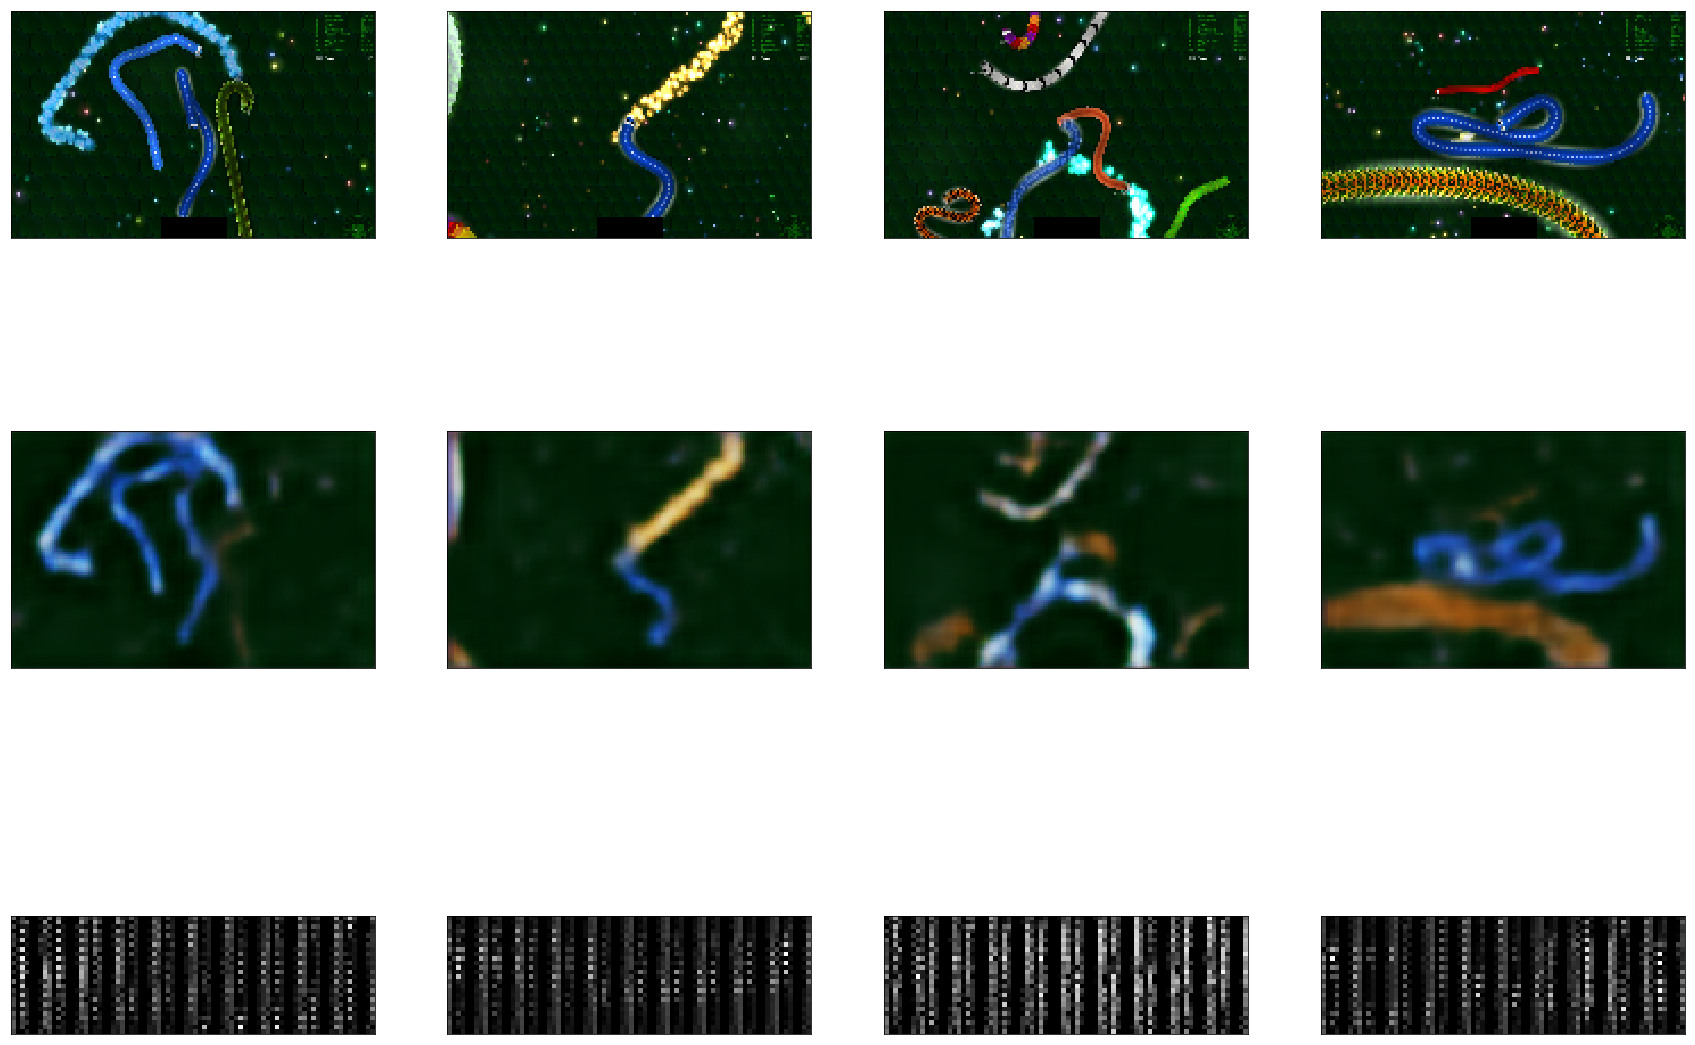

In [40]:
model.save("models/" + MODEL_NAME)


import matplotlib.pyplot as plt
import random
import numpy as np

#feed = np.array([ [ random.random() for j in range(128)]  for i in range(50) ]).reshape((-1, 4, 4, 8))
#print(feed.shape)
decoded_imgs = model.predict(x_test[:500])
encoded_imgs = encode(x_train[:500])

#print(decoded_imgs[0])
#print(x_test[0])
bias = random.randint(0,490)
n = 4
plt.figure(figsize=(30, 30))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, 1+i)
    plt.imshow(x_test[i+bias].reshape(HEIGHT, WIDTH,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display hidden state
    ax = plt.subplot(4, n, i + 2*n+1)
    plt.imshow(encoded_imgs[i+bias].reshape(13*2, 5*4*4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + n+1)
    plt.imshow(decoded_imgs[i+bias].reshape(104, WIDTH,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    
plt.show()

In [1]:
import numpy as np
import cv2

data = np.load("preprocessed_data_local_notshuffled/preprocessed-10000-20000.npy")[:,0]